In [7]:
from os import path

import matplotlib.pyplot as plt
import bnlearn as bn
from pgmpy.factors.discrete import TabularCPD

In [8]:
probs = {
    # probability distribution of genes_count={0,1,2}
    "genes_count": [0.96, 0.03, 0.01],
    # item: Probability distribution of trait=item_index given genes_count={0,1,2}
    "trait|genes_count": [[0.99, 0.44, 0.35], [0.01, 0.56, 0.65]],
    # probability distribution of mutation={0,1}
    "mutation": [0.99, 0.01],
}

[bnlearn] >bayes DAG created.
[bnlearn] >Add CPD: mother_gene
[bnlearn] >Add CPD: father_gene
[bnlearn] >Add CPD: mother_trait
[bnlearn] >Add CPD: father_trait
[bnlearn] >Add CPD: child_gene
[bnlearn] >Add CPD: child_trait
[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


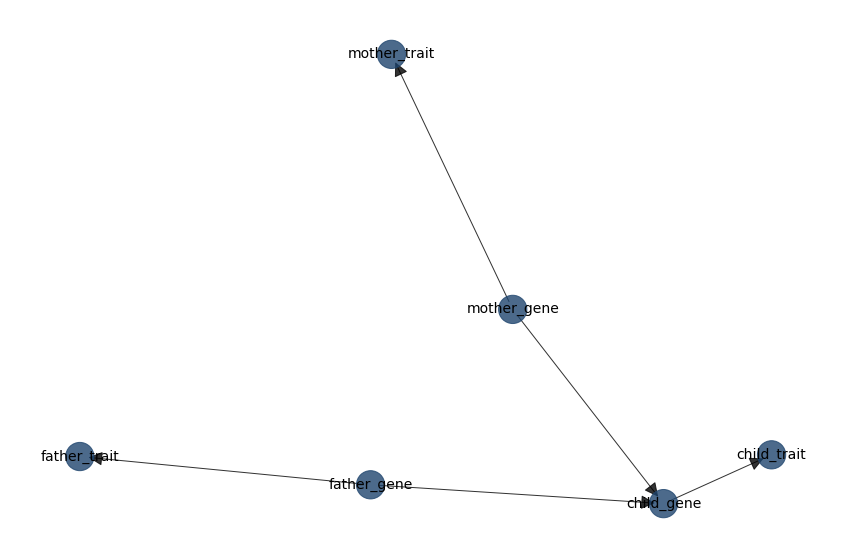

In [9]:
heredity_graph = [
    ("mother_gene", "mother_trait"),
    ("father_gene", "father_trait"),
    ("mother_gene", "child_gene"),
    ("father_gene", "child_gene"),
    ("child_gene", "child_trait"),
]

bnlean_gene_prob = [[prob] for prob in probs["genes_count"]]
one_zero = 0.5 * probs["mutation"][1] + 0.5 * probs["mutation"][0]
zero_zero = 0.5 * probs["mutation"][0] + 0.5 * probs["mutation"][0]
one_one = 0.5 * probs["mutation"][1] + 0.5 * probs["mutation"][1]

model = bn.make_DAG(
    DAG=heredity_graph,
    CPD=[
        TabularCPD(variable="mother_gene", variable_card=3, values=bnlean_gene_prob),
        TabularCPD(variable="father_gene", variable_card=3, values=bnlean_gene_prob),
        TabularCPD(
            variable="mother_trait",
            variable_card=2,
            values=probs["trait|genes_count"],
            evidence=["mother_gene"],
            evidence_card=[3],
        ),
        TabularCPD(
            variable="father_trait",
            variable_card=2,
            values=probs["trait|genes_count"],
            evidence=["father_gene"],
            evidence_card=[3],
        ),
        TabularCPD(
            variable="child_gene",
            variable_card=3,
            values=[
                [
                    # cg=0 | mg=0, fg=0
                    probs["mutation"][0] * probs["mutation"][0],
                    # cg=0 | mg=0, fg=1
                    probs["mutation"][0] * one_zero,
                    # cg=0 | mg=0, fg=2
                    probs["mutation"][0] * probs["mutation"][1],
                    # cg=0 | mg=1, fg=0
                    one_zero * probs["mutation"][0],
                    # cg=0 | mg=1, fg=1
                    one_zero * one_zero,
                    # cg=0 | mg=1, fg=2
                    one_zero * probs["mutation"][1],
                    # cg=0 | mg=2, fg=0
                    probs["mutation"][1] * probs["mutation"][0],
                    # cg=0 | mg=2, fg=1
                    probs["mutation"][1] * one_zero,
                    # cg=0 | mg=2, fg=2
                    probs["mutation"][1] * probs["mutation"][1],
                ],
                [
                    # cg=1 | mg=0, fg=0
                    (probs["mutation"][1] * probs["mutation"][0])
                    + (probs["mutation"][0] * probs["mutation"][1]),
                    # cg=1 | mg=0, fg=1
                    (probs["mutation"][1] * one_zero)
                    + (probs["mutation"][0] * one_zero),
                    # cg=1 | mg=0, fg=2
                    (probs["mutation"][1] * probs["mutation"][1])
                    + (probs["mutation"][0] * probs["mutation"][0]),
                    # cg=1 | mg=1, fg=0
                    (one_zero * probs["mutation"][0])
                    + (one_zero * probs["mutation"][1]),
                    # cg=1 | mg=1, fg=1
                    (one_zero * one_zero) + (one_zero * one_zero),
                    # cg=1 | mg=1, fg=2
                    (one_zero * probs["mutation"][1])
                    + (one_zero * probs["mutation"][0]),
                    # cg=1 | mg=2, fg=0
                    (probs["mutation"][0] * probs["mutation"][0])
                    + (probs["mutation"][1] * probs["mutation"][1]),
                    # cg=1 | mg=2, fg=1
                    (probs["mutation"][1] * one_zero)
                    + (probs["mutation"][0] * one_zero),
                    # cg=1 | mg=2, fg=2
                    (probs["mutation"][0] * probs["mutation"][1])
                    + (probs["mutation"][1] * probs["mutation"][0]),
                ],
                [
                    # cg=2 | mg=0, fg=0
                    probs["mutation"][1] * probs["mutation"][1],
                    # cg=2 | mg=0, fg=1
                    probs["mutation"][1] * one_zero,
                    # cg=2 | mg=0, fg=2
                    probs["mutation"][1] * probs["mutation"][0],
                    # cg=2 | mg=1, fg=0
                    one_zero * probs["mutation"][1],
                    # cg=2 | mg=1, fg=1
                    one_zero * one_zero,
                    # cg=2 | mg=1, fg=2
                    one_zero * probs["mutation"][0],
                    # cg=2 | mg=2, fg=0
                    probs["mutation"][0] * probs["mutation"][1],
                    # cg=2 | mg=2, fg=1
                    probs["mutation"][0] * one_zero,
                    # cg=2 | mg=2, fg=2
                    probs["mutation"][0] * probs["mutation"][0],
                ],
            ],
            evidence=["mother_gene", "father_gene"],
            evidence_card=[3, 3],
        ),
        TabularCPD(
            variable="child_trait",
            variable_card=2,
            values=probs["trait|genes_count"],
            evidence=["child_gene"],
            evidence_card=[3],
        ),
    ],
)

bn.plot(model)
plt.show()

In [12]:
def parse_family(data_path):
    if not path.isfile(data_path):
        return

    family = {}

    with open(data_path) as buffer:
        for line in buffer.read().splitlines()[1:]:
            name, mother, father, trait = line.split(",")
            family[name] = {
                "parents": {"mother": mother, "father": father}
                if mother and father
                else None,
                "trait": int(trait) if trait else None,
            }

    return family


family = parse_family(input("Family file: "))

for name in family:
    evidence = {}

    print(f"- {name}")

    if family[name]["parents"]:
        for parent, parent_name in family[name]["parents"].items():
            if family[parent_name]["trait"] is not None:
                evidence[f"{parent}_trait"] = family[parent_name]["trait"]

        if family[name]["trait"] is not None:
            evidence["child_trait"] = family[name]["trait"]
        else:
            trait_probs = (
                bn.inference.fit(
                    model=model, variables=["child_trait"], evidence=evidence, verbose=0
                )
                .df["p"]
                .values
            )

            print("  - Trait probabilities:")
            for i, prob in enumerate(trait_probs):
                print(f"    - P({i}): {prob:.{4}f}")

        gene_probs = (
            bn.inference.fit(
                model=model, variables=["child_gene"], evidence=evidence, verbose=0
            )
            .df["p"]
            .values
        )

        print("  - Gene probabilities:")
        for i, prob in enumerate(gene_probs):
            print(f"    - P({i}): {prob:.{4}f}")

        continue

    parent = next(
        dict((value, key) for key, value in personInfo["parents"].items())[name]
        for personInfo in family.values()
        if personInfo.get("parents") and name in personInfo["parents"].values()
    )

    if family[name]["trait"] is not None:
        evidence[f"{parent}_trait"] = family[name]["trait"]
    else:
        trait_probs = (
            bn.inference.fit(
                model=model, variables=[f"{parent}_trait"], evidence=evidence, verbose=0
            )
            .df["p"]
            .values
        )

        print("  - Trait probabilities:")
        for i, prob in enumerate(trait_probs):
            print(f"    - P({i}): {prob:.{4}f}")

    gene_probs = (
        bn.inference.fit(
            model=model, variables=[f"{parent}_gene"], evidence=evidence, verbose=0
        )
        .df["p"]
        .values
    )

    print("  - Gene probabilities:")
    for i, prob in enumerate(gene_probs):
        print(f"    - P({i}): {prob:.{4}f}")

- Arthur
  - Gene probabilities:
    - P(0): 0.9827
    - P(1): 0.0136
    - P(2): 0.0036
- Hermione
  - Gene probabilities:
    - P(0): 0.9827
    - P(1): 0.0136
    - P(2): 0.0036
- Molly
  - Trait probabilities:
    - P(0): 0.9671
    - P(1): 0.0329
  - Gene probabilities:
    - P(0): 0.9600
    - P(1): 0.0300
    - P(2): 0.0100
- Ron
  - Gene probabilities:
    - P(0): 0.9753
    - P(1): 0.0244
    - P(2): 0.0003
- Rose
  - Gene probabilities:
    - P(0): 0.2993
    - P(1): 0.6924
    - P(2): 0.0083
